<a href="https://colab.research.google.com/github/MobinaSedaghat/multi-digit-ocr/blob/main/approach_1_digit_segmentation_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Dataset Download

In [ ]:
# Download the dataset
!wget https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz

# Extract the tar.gz file
!tar -xvzf ORAND-CAR-2014.tar.gz


Streaming output truncated to the last 5000 lines.
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004006.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003727.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004368.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_006406.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005617.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005230.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003850.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003293.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004967.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005234.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005513.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003051.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004463.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005193.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004030.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004672.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003002.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005737

In [ ]:
output_root_a = "/content/cropped_digits_a"
output_root_b = "/content/cropped_digits_b"

In [ ]:

car_a_train_img_dir = "/content/ORAND-CAR-2014/CAR-A/a_train_images"
car_a_train_label_path = "/content/ORAND-CAR-2014/CAR-A/a_train_gt.txt"

car_a_test_img_dir = "/content/ORAND-CAR-2014/CAR-A/a_test_images"
car_a_test_label_path = "/content/ORAND-CAR-2014/CAR-A/a_test_gt.txt"



In [ ]:
car_b_train_img_dir = "/content/ORAND-CAR-2014/CAR-B/b_train_images"
car_b_train_label_path = "/content/ORAND-CAR-2014/CAR-B/b_train_gt.txt"

car_b_test_img_dir = "/content/ORAND-CAR-2014/CAR-B/b_test_images"
car_b_test_label_path = "/content/ORAND-CAR-2014/CAR-B/b_test_gt.txt"

In [ ]:
import os, cv2, numpy as np, pandas as pd
from tqdm import tqdm

# Ensure output directory exists
os.makedirs(output_root_a, exist_ok=True)

# Load ground-truth labels
label_dict_a = {}
with open(car_a_train_label_path, 'r') as f:
    for line in f:
        name, label = line.strip().split()
        label_dict_a[os.path.splitext(name)[0]] = label

# Digit Segmentation

In [ ]:
def find_threshold(gray, target_count, min_t=50, max_t=210):
    best_t, best_diff = 128, float('inf')
    for t in range(min_t, max_t+1, 5):
        _, binary = cv2.threshold(gray, t, 255, cv2.THRESH_BINARY_INV)
        n_lbl, _, stats, _ = cv2.connectedComponentsWithStats(binary)
        count = sum(1 for i in range(1, n_lbl) if stats[i][4] > 100 and stats[i][3] > 10)
        diff = abs(count - target_count)
        if diff < best_diff:
            best_diff = diff
            best_t = t
    return best_t

def fix_box_count(boxes, target_n, img_w, img_h, expand_pixels=8):
    boxes.sort(key=lambda b: b[0])
    if len(boxes) == 0:
        w = img_w // target_n
        boxes = [(i * w, 0, w, img_h) for i in range(target_n)]
    while len(boxes) < target_n:
        i = max(range(len(boxes)), key=lambda i: boxes[i][2])
        x, y, w, h = boxes.pop(i)
        boxes.insert(i, (x, y, w // 2, h))
        boxes.insert(i + 1, (x + w // 2, y, w - w // 2, h))
    while len(boxes) > target_n:
        boxes.sort(key=lambda b: b[0])
        i = 0
        x1, y1, w1, h1 = boxes.pop(i)
        x2, y2, w2, h2 = boxes.pop(i)
        x = min(x1, x2)
        y = min(y1, y2)
        w = max(x1 + w1, x2 + w2) - x
        h = max(y1 + h1, y2 + h2) - y
        boxes.insert(i, (x, y, w, h))

    # Expand boxes by expand_pixels on all sides, clip to image bounds
    expanded_boxes = []
    for (x, y, w, h) in boxes:
        x_new = max(0, x - expand_pixels)
        y_new = max(0, y - expand_pixels)
        w_new = min(img_w - x_new, w + 2 * expand_pixels)
        h_new = min(img_h - y_new, h + 2 * expand_pixels)
        expanded_boxes.append((x_new, y_new, w_new, h_new))

    return expanded_boxes



In [ ]:
def prepare_dataset(image_dir, label_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    label_dict = {}
    with open(label_path, 'r') as f:
        for line in f:
            name, label = line.strip().split()
            label_dict[os.path.splitext(name)[0]] = label

    for filename in tqdm(os.listdir(image_dir), desc=f"Preparing {output_dir}"):
        if not filename.endswith(".png"):
            continue
        file_id = os.path.splitext(filename)[0]
        if file_id not in label_dict:
            continue
        label = label_dict[file_id]
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        h, w = img.shape
        thresh_val = find_threshold(img, len(label))
        _, binary = cv2.threshold(img, thresh_val, 255, cv2.THRESH_BINARY_INV)
        n_lbl, _, stats, _ = cv2.connectedComponentsWithStats(binary)
        boxes = []
        for i in range(1, n_lbl):
            x, y, bw, bh, area = stats[i]
            if area > 100 and bh > 10:
                boxes.append((x, y, bw, bh))
        boxes = fix_box_count(boxes, len(label), w, h)
        boxes.sort(key=lambda b: b[0])
        digit_folder = os.path.join(output_dir, file_id)
        os.makedirs(digit_folder, exist_ok=True)
        for i, (x, y, bw, bh) in enumerate(boxes):
            digit_crop = img[y:y+bh, x:x+bw]
            save_path = os.path.join(digit_folder, f"{i}.png")
            cv2.imwrite(save_path, digit_crop)
    return label_dict


In [ ]:
print("Number of images:", len(os.listdir(car_a_train_img_dir)))


Number of images: 2009


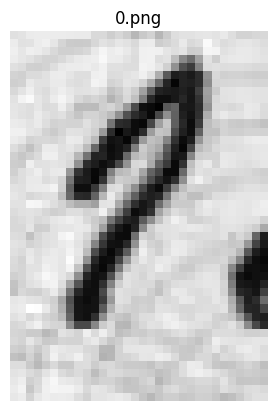

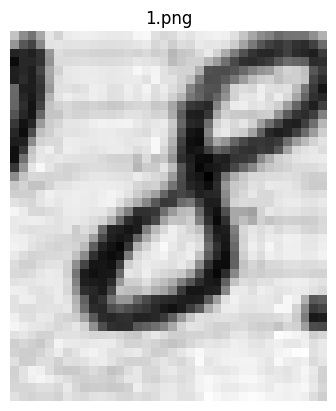

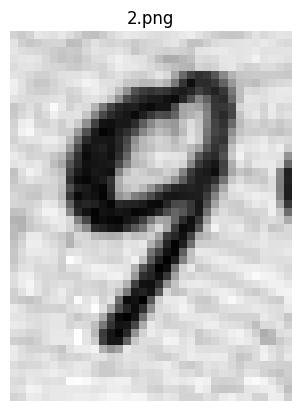

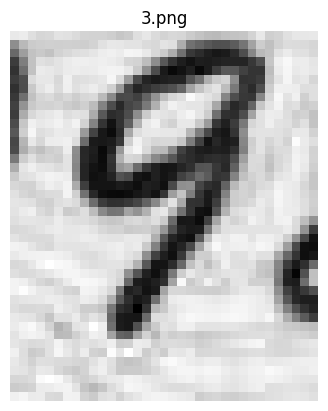

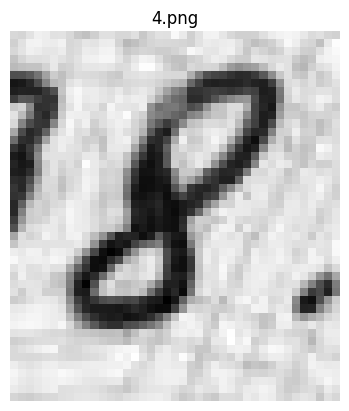

In [ ]:
import cv2, os
import matplotlib.pyplot as plt

folder_path = os.path.join(output_root_a, 'a_car_000165')

for img_name in sorted(os.listdir(folder_path)):
    if not img_name.endswith('.png'):
        continue
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(img_name)
    plt.axis('off')
    plt.show()


# Load segmented digits and labels

In [ ]:
from tensorflow.keras.utils import to_categorical

def load_segmented_digits(image_root, label_dict, img_size=(28, 28)):
    X = []
    y = []
    skipped = 0
    for folder in tqdm(os.listdir(image_root)):
        folder_path = os.path.join(image_root, folder)
        if not os.path.isdir(folder_path):
            continue
        if folder not in label_dict:
            skipped += 1
            continue
        label_seq = label_dict[folder]
        for i, fname in enumerate(sorted(os.listdir(folder_path))):
            if not fname.endswith('.png') or i >= len(label_seq):
                continue
            img_path = os.path.join(folder_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = img.astype("float32") / 255.0
            img = np.expand_dims(img, axis=-1)
            X.append(img)
            y.append(int(label_seq[i]))
    print(f"Loaded {len(X)} digits. Skipped {skipped} folders without labels.")
    return np.array(X), to_categorical(y, num_classes=10)





# CNN Model for Digit Classification



In [ ]:
def build_and_train_model(X, y):
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)
    X_train_raw = (X_train * 255).astype("uint8")

    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=3,
        width_shift_range=0.03,
        height_shift_range=0.03,
        zoom_range=0.03,
        brightness_range=[0.98, 1.02],
        shear_range=0.01,
        fill_mode='nearest'
    )

    train_generator = datagen.flow(X_train_raw, y_train, batch_size=64, shuffle=True)

    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), padding='same'), BatchNormalization(), Activation('relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), padding='same'), BatchNormalization(), Activation('relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(train_generator, validation_data=(X_test, y_test), epochs=50, steps_per_epoch=len(X_train) // 64, callbacks=[early_stop])
    loss, acc = model.evaluate(X_test, y_test)
    return model, acc


In [ ]:
def predict_full_number(img_path, label, model):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    h, w = img.shape

    thresh_val = find_threshold(img, len(label))
    _, binary = cv2.threshold(img, thresh_val, 255, cv2.THRESH_BINARY_INV)
    n_lbl, _, stats, _ = cv2.connectedComponentsWithStats(binary)

    boxes = []
    for i in range(1, n_lbl):
        x, y, bw, bh, area = stats[i]
        if area > 100 and bh > 10:
            boxes.append((x, y, bw, bh))

    boxes = fix_box_count(boxes, len(label), w, h)
    boxes.sort(key=lambda b: b[0])

    digit_crops = []
    for (x, y, bw, bh) in boxes:
        digit_crop = img[y:y+bh, x:x+bw]
        digit_resized = cv2.resize(digit_crop, (28, 28))
        digit_resized = digit_resized.astype('float32') / 255.0
        digit_crops.append(digit_resized)

    digit_batch = np.array(digit_crops).reshape(-1, 28, 28, 1)
    predictions = model.predict(digit_batch, verbose=0)
    predicted_digits = [str(np.argmax(p)) for p in predictions]

    return ''.join(predicted_digits)


# Training

In [ ]:
# A
label_dict_a = prepare_dataset(car_a_train_img_dir, car_a_train_label_path, output_root_a)
X_a, y_a = load_segmented_digits(output_root_a, label_dict_a)
model_a, acc_a = build_and_train_model(X_a, y_a)

# B
label_dict_b = prepare_dataset(car_b_train_img_dir, car_b_train_label_path, output_root_b)
X_b, y_b = load_segmented_digits(output_root_b, label_dict_b)
model_b, acc_b = build_and_train_model(X_b, y_b)

# A + B
X_ab = np.concatenate([X_a, X_b])
y_ab = np.concatenate([y_a, y_b])
model_ab, acc_ab = build_and_train_model(X_ab, y_ab)


print(f"Model A Accuracy: {acc_a:.2%}")
print(f"Model B Accuracy: {acc_b:.2%}")
print(f"Model A+B Accuracy: {acc_ab:.2%}")


100%|██████████| 2009/2009 [00:00<00:00, 2130.32it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loaded 9076 digits. Skipped 0 folders without labels.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.2314 - loss: 2.4134 - val_accuracy: 0.2131 - val_loss: 2.2437
Epoch 2/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5000 - loss: 1.5915

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 1.5915 - val_accuracy: 0.2131 - val_loss: 2.2443
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5159 - loss: 1.5403 - val_accuracy: 0.2704 - val_loss: 2.1625
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 1.2634 - val_accuracy: 0.2759 - val_loss: 2.1623
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5867 - loss: 1.3263 - val_accuracy: 0.3607 - val_loss: 1.9279
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 1.0127 - val_accuracy: 0.3596 - val_loss: 1.9230
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6651 - loss: 1.1454 - val_accuracy: 0.5628 - val_loss: 1.4301
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 1.1838 - val_accuracy: 0.5589 - val_loss: 1.4321
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6922 - loss: 1.0639 - val_accuracy: 0.7076 -

100%|██████████| 3000/3000 [00:01<00:00, 1684.84it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loaded 16813 digits. Skipped 0 folders without labels.
Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4211 - loss: 1.9684 - val_accuracy: 0.4404 - val_loss: 1.8838
Epoch 2/50
  1/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5625 - loss: 1.4758

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 1.4758 - val_accuracy: 0.4404 - val_loss: 1.8846
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.5976 - loss: 1.3373 - val_accuracy: 0.5257 - val_loss: 1.4535
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 1.3153 - val_accuracy: 0.5251 - val_loss: 1.4519
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6650 - loss: 1.1471 - val_accuracy: 0.7023 - val_loss: 1.0719
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 1.3485 - val_accuracy: 0.7021 - val_loss: 1.0730
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7029 - loss: 1.0556 - val_accuracy: 0.7297 - val_loss: 1.0104
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.8364 - val_accuracy: 0.7285 - val_loss: 1.0130
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7289 - loss: 0.9834 - val_accuracy: 0.7484 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


323/323 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.4041 - loss: 1.9474 - val_accuracy: 0.3694 - val_loss: 1.8273
Epoch 2/50
  1/323 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6406 - loss: 1.1869

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6406 - loss: 1.1869 - val_accuracy: 0.3698 - val_loss: 1.8264
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6381 - loss: 1.2288 - val_accuracy: 0.7115 - val_loss: 1.0226
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 1.1512 - val_accuracy: 0.7088 - val_loss: 1.0268
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.6968 - loss: 1.0779 - val_accuracy: 0.7572 - val_loss: 0.9336
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7344 - loss: 1.2206 - val_accuracy: 0.7580 - val_loss: 0.9358
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7372 - loss: 0.9625 - val_accuracy: 0.7769 - val_loss: 0.8858
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7969 - loss: 0.8706 - val_accuracy: 0.7756 - val_loss: 0.8863
Epoch 9/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7548 - loss: 0.9081 - val_accuracy: 0.769

In [ ]:
#ََA
correct_a = 0
total_a = 0

for file_id, true_label in label_dict_a.items():
    img_path = os.path.join(car_a_train_img_dir, file_id + ".png")
    if not os.path.exists(img_path):
        continue
    predicted = predict_full_number(img_path, true_label, model_a)
    if predicted == true_label:
        correct_a += 1
    total_a += 1

print(f"Model A Full Number Accuracy: {correct_a}/{total_a} = {correct_a/total_a:.2%}")


Model A Full Number Accuracy: 1271/2009 = 63.27%


In [ ]:
#B
correct_b = 0
total_b = 0

for file_id, true_label in label_dict_b.items():
    img_path = os.path.join(car_b_train_img_dir, file_id + ".png")
    if not os.path.exists(img_path):
        continue
    predicted = predict_full_number(img_path, true_label, model_b)
    if predicted == true_label:
        correct_b += 1
    total_b += 1

print(f"Model B Full Number Accuracy: {correct_b}/{total_b} = {correct_b/total_b:.2%}")


Model B Full Number Accuracy: 1421/3000 = 47.37%


In [ ]:
#A+B
correct_ab = 0
total_ab = 0

combined_label_dict = {**label_dict_a, **label_dict_b}
combined_img_paths = {**{k: os.path.join(car_a_train_img_dir, k + ".png") for k in label_dict_a},
                      **{k: os.path.join(car_b_train_img_dir, k + ".png") for k in label_dict_b}}

for file_id, true_label in combined_label_dict.items():
    img_path = combined_img_paths[file_id]
    if not os.path.exists(img_path):
        continue
    predicted = predict_full_number(img_path, true_label, model_ab)
    if predicted == true_label:
        correct_ab += 1
    total_ab += 1

print(f"Model A+B Full Number Accuracy: {correct_ab}/{total_ab} = {correct_ab/total_ab:.2%}")


Model A+B Full Number Accuracy: 2961/5009 = 59.11%


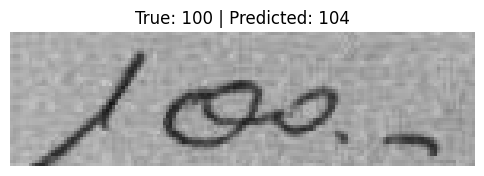

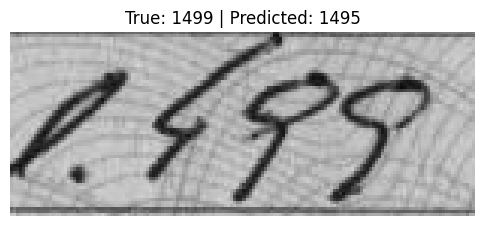

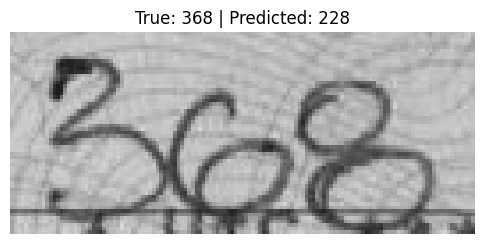

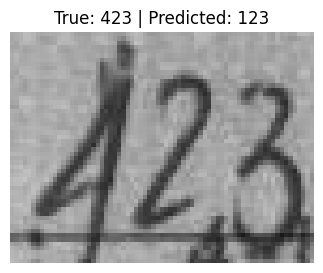

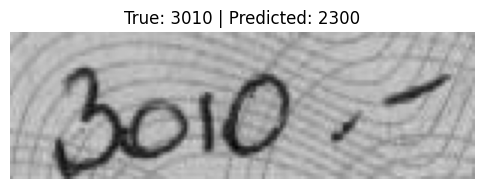

In [ ]:
import matplotlib.pyplot as plt

shown = 0
num_to_show = 5

for file_id, true_label in label_dict_a.items():
    img_path = os.path.join(car_a_train_img_dir, file_id + ".png")
    if not os.path.exists(img_path):
        continue

    predicted_label = predict_full_number(img_path, true_label, model_a)

    if predicted_label != true_label:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 3))
        plt.imshow(img_rgb)
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        shown += 1
        if shown >= num_to_show:
            break


In [ ]:
y_true_digits = []
y_pred_digits = []

for file_id, true_label in label_dict_a.items():
    img_path = os.path.join(car_a_train_img_dir, file_id + ".png")
    pred_label = predict_full_number(img_path, true_label, model_a)
    if pred_label is None or len(pred_label) != len(true_label):
        continue
    y_true_digits.extend([int(ch) for ch in true_label])
    y_pred_digits.extend([int(ch) for ch in pred_label])


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.grid(False)
    plt.show()


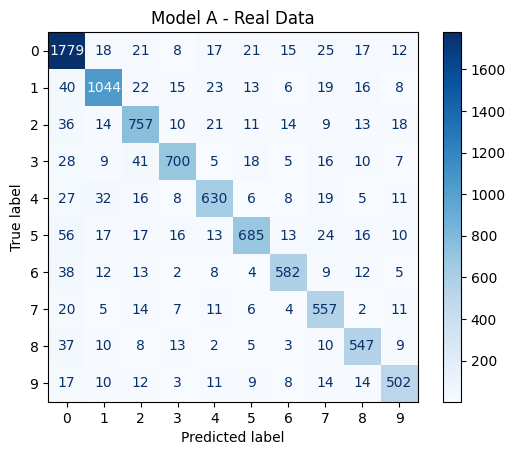

In [ ]:
plot_confusion_matrix(y_true_digits, y_pred_digits, title="Model A - Real Data")
